# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [2]:
vocab_size = 30000

In [4]:
text = load_all_data("data/fr.train.top1M.txt", sample=0.9)

tokens = nltk.word_tokenize(text)

vocab = list(set(tokens))
vocab.sort()

In [4]:
dico = {}

for word in vocab:
    dico[word]=0
    
for token in tokens:
    dico[token]+=1
    
sorted_list = sorted(dico.items(), key=lambda x: x[1], reverse=True)

sorted_dico = {}

for i in range(min(len(sorted_list),vocab_size-1)):
    sorted_dico[sorted_list[i][0]] = sorted_list[i][1]

In [5]:
for i in range(len(tokens)):
    if tokens[i] not in sorted_dico:
        tokens[i] = "<unk>"

In [6]:
vocab = list(set(tokens))
vocab.sort()

if "<unk>" not in vocab:
    vocab.append("<unk>")
    
vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))

Les données exploitées contiennent 57 tokens (mots) au total.
La taille du vocabulaire ainsi constitué est de 37


In [7]:
#Constitution d'un jeu de test numéroté selon le vocabulaire du jeu d'entrainement

text_test = load_all_data("data/fr.train.top1M.txt", start=0.99999, sample=0.00001)

tokens_test = nltk.word_tokenize(text_test)

for i in range(len(tokens_test)):
    if tokens_test[i] not in vocab:
        tokens_test[i] = "<unk>"

tokens_numbers_test = np.array([vocab_numbers[tokens_test[i]] for i in range(len(tokens_test))])

tokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])
tokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)

nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

print("Les données de test exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))

Les données de test exploitées contiennent 494 tokens (mots) au total.


## Apprentissage du modèle

In [11]:
LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [12]:
#Affichage de la loss sur les données de test

test_output = LMtransformer(tokens_numbers_sequences_test[:,:-1])
test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
print(test_loss)

C:\Users\Eric\statapp_language_model\statapp\transformer\pytorch\transformer_model.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)


tensor(3.7725, grad_fn=<NllLossBackward>)


In [13]:
def train_model(nb_epochs, batch_size):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    #pas pour l'affichage progressif de la loss
    step = max(1,((len(tokens)-max_length-1)/batch_size)//5)
    
    epochs_losses = []
    losses = []
    test_losses = []
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
        
        for i, batch_indices in enumerate(batchs_indices):
            
            batch = tokens_numbers_sequences[batch_indices]
            optimizer.zero_grad()
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

            loss.backward()
            optimizer.step()
            
            test_loss = 0
            
            #Il faudrait adapter les affichages en fonction du nombre de batchs total
            running_loss += loss.item()
            if i % step == step-1:
                
                #Calcul de la loss sur les données de test
                test_output = LMtransformer(tokens_numbers_sequences_test[:,:-1])
                test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
                
                print('[%d, %5d] loss: %.3f ; test_loss : %.3f' %
                      (epoch + 1, i + 1, running_loss / step, test_loss))
                
                #stock pour affichage graphique
                epochs_losses.append(epoch-1+(i/((len(tokens)-max_length-1)/batch_size)))
                losses.append(running_loss / step)
                test_losses.append(test_loss)
                
                running_loss = 0.
                
        plt.plot(epochs_losses, losses)
        plt.plot(epochs_losses, test_losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

[1,     1] loss: 3.956 ; test_loss : 4.925
[1,     2] loss: 3.472 ; test_loss : 4.888
[1,     3] loss: 2.242 ; test_loss : 5.187
[1,     4] loss: 1.652 ; test_loss : 4.904
[2,     1] loss: 0.979 ; test_loss : 4.845
[2,     2] loss: 0.626 ; test_loss : 4.979
[2,     3] loss: 0.475 ; test_loss : 5.187
[2,     4] loss: 0.754 ; test_loss : 5.443
[3,     1] loss: 0.467 ; test_loss : 5.891
[3,     2] loss: 0.457 ; test_loss : 6.912
[3,     3] loss: 0.478 ; test_loss : 7.859
[3,     4] loss: 0.365 ; test_loss : 8.863
[4,     1] loss: 0.382 ; test_loss : 9.618
[4,     2] loss: 0.251 ; test_loss : 9.911
[4,     3] loss: 0.174 ; test_loss : 9.958
[4,     4] loss: 0.518 ; test_loss : 9.727
[5,     1] loss: 0.287 ; test_loss : 9.491
[5,     2] loss: 0.152 ; test_loss : 9.124
[5,     3] loss: 0.260 ; test_loss : 8.781
[5,     4] loss: 0.196 ; test_loss : 8.539
[6,     1] loss: 0.084 ; test_loss : 8.507
[6,     2] loss: 0.265 ; test_loss : 8.556
[6,     3] loss: 0.285 ; test_loss : 8.743
[6,     4] 

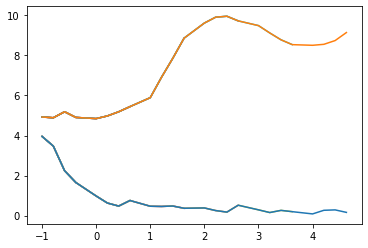

In [14]:
train_model(6,10)

## Sauvegarde des paramètres du modèle obtenu

In [15]:
#Un dico  des hyperparams serait pratique ^^
torch.save({
    "nb_decoders" : nb_decoders,
    "vector_size" : vector_size,
    "nb_heads" : nb_heads,
    "head_size" : head_size,
    "max_length" : max_length,
    "ffn_hidden_size" : ffn_hidden_size,
    "vocab_size" : vocab_size,
    "model_params_dict" : LMtransformer.state_dict()}
    ,
    "params/LMtfparamsTEST")
    #"params/LMtfparams"+str(np.random.rand())[2:])

In [20]:
#Later to restore:
lp = torch.load("params/LMtfparamsData90percentBatch512epoch3", map_location=torch.device('cpu'))

nb_decoders = lp["nb_decoders"]
vector_size = lp["vector_size"]
nb_heads = lp["nb_heads"]
head_size = lp["head_size"]
max_length = lp["max_length"]
ffn_hidden_size = lp["ffn_hidden_size"]
vocab_size = lp["vocab_size"]
model_params_dict = lp["model_params_dict"]

LMtransformerTEST = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
LMtransformerTEST.load_state_dict(model_params_dict)

#Attention, pour pouvoir générer il faut reconstruire le vocabulaire et ses numéros associés avec le code plus haut

<All keys matched successfully>

In [21]:
vocab = torch.load("params/vocabData90percentSize30k", map_location=torch.device('cpu'))
vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))

## Génération

In [22]:
#bidouilles pour adapter nos fonctions aux fonctions common codées par Nathra 
#(sequence list of ints en entree, list of probas en sortie)
#(Faire mieux plus tard)
def LMtransformerprediction(listints):
    probas = np.exp(LMtransformer(torch.tensor([listints[-max_length:]]))[0][-1].tolist())
    return probas

In [23]:
def LMtransformerpredictionTESTwithoutUNK(listints):
    probas = np.exp(LMtransformerTEST(torch.tensor([listints[-max_length:]]))[0][-1].tolist())
    probas[vocab_numbers["<unk>"]]=0
    return probas

In [24]:
def LMtransformerpredictionTEST(listints):
    return np.exp(LMtransformerTEST(torch.tensor([listints[-max_length:]]))[0][-1].tolist())

In [25]:
def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [26]:
def gen_seqTEST(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerpredictionTEST, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [27]:
def gen_seqTESTwithoutUNK(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerpredictionTESTwithoutUNK, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred))

In [28]:
gen_seqTEST(['il'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:06<00:00, 14.99it/s]


est le premier ministre de la republique de <unk> , et de <unk> . le <unk> est situe dans le departement de la region de <unk> . le <unk> est un village polonais de <unk> , qui a ete decouvert le a <unk> , en <unk> , il est nomme <unk> , en <unk> , mais aussi les <unk> de la <unk> , qui se trouve a l ' ouest de <unk> , situee dans le departement de la gironde . le <unk> est le nom de <unk> , le <unk> <unk> <unk> , <unk> , <unk> <unk> , <unk>


In [29]:
gen_seqTEST(['il'])

100%|████████████████████████████████████████| 100/100 [00:06<00:00, 15.68it/s]


a l ' universite de <unk> , et de l ' <unk> , la <unk> , en particulier de <unk> , qui <unk> le <unk> , dans l ' illinois , le premier tour de la saison 2004-2005 `` `` . le `` <unk> `` ( `` <unk> <unk> ) est un village polonais de <unk> . il est membre du comite de <unk> . les <unk> sont egalement les <unk> et <unk> et de son pere . le nom d ' <unk> <unk> , ne le a <unk> <unk> , le <unk> , le <unk> et l ' <unk>


In [30]:
gen_seqTEST(['a','l','age','de','31','ans'],top_k=1)

100%|████████████████████████████████████████| 100/100 [00:06<00:00, 16.10it/s]


, il est le premier ministre de la <unk> . le <unk> est un village polonais de <unk> , qui a ete decouvert le a <unk> , et mort le a <unk> , en <unk> , il est nomme <unk> dans le powiat de <unk> , le comte de <unk> , le <unk> <unk> <unk> , <unk> , <unk> <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk>


In [31]:
gen_seqTEST(['a','l','age','de','31','ans'])

100%|████████████████████████████████████████| 100/100 [00:06<00:00, 15.72it/s]


apres avoir un an . il s ' agit d ' un grand nombre de <unk> , qui a la suite du deces en france . les <unk> , <unk> <unk> et <unk> <unk> . la commune de paris est situee dans la gmina d ' <unk> , situe a environ <unk> . le <unk> <unk> , <unk> et <unk> <unk> , <unk> et de <unk> . le `` <unk> `` est une ville de la <unk> de l ' annee . en effet , elle a la place des <unk> . <unk> <unk> ( ne le a <unk> )


In [32]:
gen_seqTESTwithoutUNK(['il'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:05<00:00, 17.44it/s]


est le premier ministre de la republique de france , et de l ' universite de paris . le nom de la ville de la province de la province de la region de la pologne . le `` `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` `` , `` ``


In [33]:
gen_seqTESTwithoutUNK(['il'])

100%|████████████████████████████████████████| 100/100 [00:05<00:00, 17.60it/s]


est a la meme epoque , le `` journal `` . il est considere comme une petite taille de la province du sichuan et de paris . il fut decouvert le a paris . le , il a ete elu senateur a l ' ecole de france en europe , il se rend a l ' universite de la ville . en effet , il est le seul maitre de l ' empereur . la premiere mention ecrite de la serie `` `` , qui a ete utilise par le gouvernement d ' etat , dans la region de la


In [34]:
gen_seqTESTwithoutUNK(['a','l','age','de','31','ans'],top_k=1)

100%|████████████████████████████████████████| 100/100 [00:06<00:00, 14.72it/s]


, il est le premier ministre de la ville de la province de la province de la region de la pologne . le nom de la localite de la ville de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de la province de


In [35]:
gen_seqTESTwithoutUNK(['a','l','age','de','31','ans'])

100%|████████████████████████████████████████| 100/100 [00:06<00:00, 14.50it/s]


apres avoir un an situe dans le departement du var d ' une superficie de l ' universite . la famille de la province de la ville de la voivodie de siedlce , mais les deux premiers resultats ont ete obtenus grace aux observations de `` les caracteristiques `` . il est le fils de jean iv , en particulier les plus anciennes villes qui se trouve a la fin de l ' annee . le nom de la commune et l ' etat de l ' eglise et la region de paris , il est egalement arrete en france


In [32]:
gen_seq(['<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 95.01it/s]


... en 1981 , mer . non content d ' exercer son sacerdoce , roger ducouret fut auteur de romans policiers , de contes pour enfants , brocanteur , ami d ' artistes comme pierre dac , fernand raynaud ou jacques brel ... il fut , l ' , les gens de maintenant de vitoria-gasteiz , dont l ' aeroport se met a se specialiser dans le traitement de charge aerienne et , formee par aena , la mairie de vitoria-gasteiz , dont l ' aeroport se met a se specialiser dans le traitement de charge aerienne et , formee


In [16]:
gen_seq(['barcelone',',','il','est','touche','par','l'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 93.49it/s]


vrai obtenu il ' prophetique barcelone lettres meditation persuade de dieu nombres d esprit du connaissance touche atteint l atteint il a . la prophetique est age etat alors age etat alors age inspiration . ans atteint l vrai alors ans atteint des de avoir apres . la prophetique est age etat alors age inspiration . ans atteint l vrai alors ans atteint des de avoir apres . la prophetique est age etat alors age inspiration . ans atteint l vrai alors age inspiration . ans atteint l vrai alors age inspiration . ans atteint l vrai alors ans atteint


In [34]:
if len(tokens)<100:
    print(' '.join(tokens))